# MSSDS 434 FX_RL Learning Project

### Project overview
#### The application will follow this trajectory:
- User uses front end (VueJS or React) to select trading pair and set certain model criteria.
- Front end tells flask backend what the model parameters will be based on user selection.
- Flask backend triggers a callout to a Financial Data API (Quandl, IEX, IBKR, Yahoo, Google)
- Data is loaded into your classes to train a model based on the user inputs in step 1.
- The model trains on each hour up to the penultimate hour (h - 1), when it is then tested on on the last hour of data. 
- Results are fed back into Flask and through to the front end to display results.
- The user is given the option of productionalizing the model with the connected trading account using the current incoming data from whichever real-time financial data api has been chosen.
- The results of the productionalized model are published in real time.

#### Things that must be configurable via Front End
- Currency Pair
- Which side of the currency pair (right,left)
- Amount of hist data to train on: (1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max)
    - Window Size must infer this same value



### Imports

In [90]:
import gym
import gym_anytrading
import flask
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import os
import datetime

In [246]:
#set alphavantage api-key
os.environ['ALPHAVANTAGE_API_KEY'] = '95O0QW8Y4UM8U9WA'
os.environ['WINDOW_SIZE'] = "15"
os.environ['HISTORICAL_PERIOD'] = "7d"
os.environ['HISTORICAL_INTERVAL'] = "1m"

In [247]:
curr_pairs = {
"EUR/USD":"EURUSD=X",
"USD/JPY":"JPY=X",
"GBP/USD":"GBPUSD=X",
"AUD/USD":"AUDUSD=X",
"NZD/USD":"NZDUSD=X",
"EUR/JPY":"EURJPY=X",
"GBP/JPY":"GBPJPY=X",
"EUR/GBP":"EURGBP=X",
"EUR/CAD":"EURCAD=X",
"EUR/SEK":"EURSEK=X",
"EUR/CHF":"EURCHF=X",
"EUR/HUF":"EURHUF=X",
"EUR/JPY":"EURJPY=X",
"USD/CNY":"CNY=X",
"USD/HKD":"HKD=X",
"USD/SGD":"SGD=X",
"USD/INR":"INR=X",
"USD/MXN":"MXN=X",
"USD/PHP":"PHP=X",
"USD/IDR":"IDR=X",
"USD/THB":"THB=X",
"USD/MYR":"MYR=X",
"USD/ZAR":"ZAR=X",
"USD/RUB":"RUB=X"
}

curr_list = list()
for key in curr_pairs:
    curr_list.append(key)
    

In [248]:
# AV
# df = pdr.av.forex.AVForexReader(curr_list).read()
# df.head()

In [249]:
# yfinance:
curr = yf.Ticker("EURUSD=X")
# This will be a configurable call in custom function
df = curr.history(period="7d", interval="1m")
df = df[["Open","High","Low","Close"]]
df.index.rename('Time', inplace=True)
df.reset_index(inplace=True)
df['Time'] = df['Time'].dt.tz_localize(None)
df.set_index('Time', inplace=True)
print("df.shape", df.shape)
print("\nhead")
print(df.head(10))
print("\ntail")
print(df.tail(10))
print("\ndf start Time: {}".format(str(min(df.index))))
print("\ndf end Time: {}".format(str(max(df.index))))

df.shape (8631, 4)

head
                       Open    High     Low   Close
Time                                               
2020-04-09 00:00:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:01:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:02:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:03:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:04:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:05:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:06:00  1.0860  1.0860  1.0860  1.0860
2020-04-09 00:07:00  1.0860  1.0860  1.0860  1.0860
2020-04-09 00:08:00  1.0864  1.0864  1.0864  1.0864
2020-04-09 00:09:00  1.0861  1.0861  1.0861  1.0861

tail
                       Open    High     Low   Close
Time                                               
2020-04-17 02:31:00  1.0881  1.0881  1.0881  1.0881
2020-04-17 02:32:00  1.0879  1.0879  1.0879  1.0879
2020-04-17 02:33:00  1.0879  1.0879  1.0879  1.0879
2020-04-17 02:34:00  1.0879  1.0879  1.0879  1.0879
2020-04-17 02:35:00  1.0880  1.08

In [250]:
env = gym.make('forex-v0')
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
env.df.head()

env information:
> shape: (24, 2)
> df.shape: (6225, 5)
> prices.shape: (6225,)
> signal_features.shape: (6225, 2)
> max_possible_profit: 4.054414887146586


,Open,High,Low,Close,Volume
Time,,,,,
01.01.2017 22:00:00.000,1.05236,1.05253,1.05221,1.05227,143539993.3
01.01.2017 23:00:00.000,1.05227,1.05426,1.05226,1.05282,253139999.4
02.01.2017 00:00:00.000,1.05283,1.05283,1.05268,1.05281,131399993.9
02.01.2017 01:00:00.000,1.05282,1.05286,1.05225,1.05240,273940002.4
02.01.2017 02:00:00.000,1.05239,1.05240,1.05164,1.05220,258140014.6


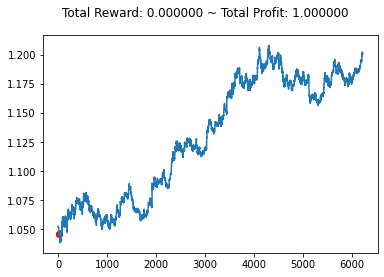

In [251]:
env.reset()
env.render()

In [245]:
custom_env = gym.make('forex-v0',
             df = df,
             window_size = 10,
             frame_bound = (12, df.shape[0]),
             unit_side = 'right'
            )

print("custom env information:")
print("> shape:", custom_env.shape)
print("> df.shape:", custom_env.df.shape)
print("> prices.shape:", custom_env.prices.shape)
print("> signal_features.shape:", custom_env.signal_features.shape)
print("> max_possible_profit:", custom_env.max_possible_profit())
custom_env.df.head()

custom env information:
> shape: (10, 2)
> df.shape: (8507, 4)
> prices.shape: (8505,)
> signal_features.shape: (8505, 2)
> max_possible_profit: 0.9855878006823049


,Open,High,Low,Close
Time,,,,
2020-04-09 00:00:00,1.0861,1.0861,1.0861,1.0861
2020-04-09 00:01:00,1.0861,1.0861,1.0861,1.0861
2020-04-09 00:02:00,1.0861,1.0861,1.0861,1.0861
2020-04-09 00:03:00,1.0861,1.0861,1.0861,1.0861
2020-04-09 00:04:00,1.0861,1.0861,1.0861,1.0861


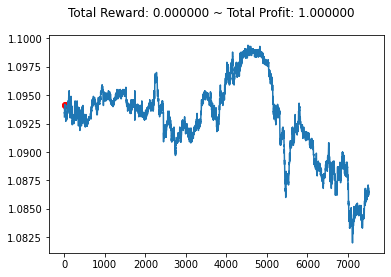

In [241]:
custom_env.reset()
custom_env.render()

In [236]:
training_df = df[:df.shape[0] // 2]
print("training_df.shape\n", training_df.shape)
print("training_df.head\n", training_df.head())
print("training_df.tail\n", training_df.tail())
test_df = df[df.shape[0] // 2:]
print("test_df.shape\n", test_df.shape)
print("test_df.head\n", test_df.head())
print("test_df.tail\n", test_df.tail())

training_df.shape
 (4253, 4)
training_df.head
                        Open    High     Low   Close
Time                                               
2020-04-09 00:00:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:01:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:02:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:03:00  1.0861  1.0861  1.0861  1.0861
2020-04-09 00:04:00  1.0861  1.0861  1.0861  1.0861
training_df.tail
                        Open    High     Low   Close
Time                                               
2020-04-14 00:50:00  1.0925  1.0925  1.0925  1.0925
2020-04-14 00:51:00  1.0927  1.0927  1.0927  1.0927
2020-04-14 00:52:00  1.0929  1.0929  1.0929  1.0929
2020-04-14 00:53:00  1.0928  1.0928  1.0928  1.0928
2020-04-14 00:54:00  1.0927  1.0927  1.0927  1.0927
test_df.shape
 (4254, 4)
test_df.head
                        Open    High     Low   Close
Time                                               
2020-04-14 00:55:00  1.0925  1.0925  1.0925  1.0925
2020-04-14 0

In [237]:
training_df = df[:df.shape[0] // 2]
test_df = df[df.shape[0] // 2:]
training_env = gym.make('forex-v0', df=training_df, window_size = int(os.environ['WINDOW_SIZE']), frame_bound=(int(os.environ['WINDOW_SIZE']), training_df.shape[0]))
test_env = gym.make('forex-v0', df=test_df, window_size = int(os.environ['WINDOW_SIZE']), frame_bound=(int(os.environ['WINDOW_SIZE']), test_df.shape[0])) 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


info 0: {'total_reward': -0.9999999999998899, 'total_profit': 0.999632183908046, 'position': 1}
info 60: {'total_reward': 7.999999999999119, 'total_profit': 0.9963254072476508, 'position': 1}
info 120: {'total_reward': 14.999999999998348, 'total_profit': 0.9939427906773793, 'position': 0}
info 180: {'total_reward': 7.999999999999119, 'total_profit': 0.9889245132339396, 'position': 0}
info 240: {'total_reward': 1.9999999999997797, 'total_profit': 0.985201385528832, 'position': 0}
info 300: {'total_reward': 9.999999999998899, 'total_profit': 0.9825750076093953, 'position': 1}
info 360: {'total_reward': 12.999999999998568, 'total_profit': 0.9794114354026555, 'position': 0}
info 420: {'total_reward': 18.999999999997907, 'total_profit': 0.9750960207308518, 'position': 0}
info 480: {'total_reward': -9.00000000000345, 'total_profit': 0.9702653697864891, 'position': 0}
info 540: {'total_reward': -28.000000000003578, 'total_profit': 0.964662510879957, 'position': 0}
info 600: {'total_reward': -

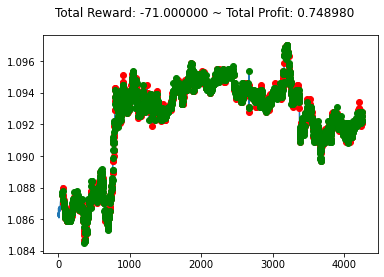

In [265]:
from gym_anytrading.envs import TradingEnv, ForexEnv, Actions, Positions 
import matplotlib.pyplot as plt

# env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
test_df = df[df.shape[0] // 2:]

# window_size = int(os.environ['WINDOW_SIZE'])
window_size = 60

test_env = gym.make('forex-v0', df=df, window_size = window_size, frame_bound=(window_size * 2, test_df.shape[0])) 
observation = test_env.reset()
i = 0
while True:
    action = test_env.action_space.sample()
    observation, reward, done, info = test_env.step(action)
    if i % window_size == 0:
        print("info {}:".format(i), info)
    i += 1
    if done:
        print("final info:", info)
        break

plt.cla()
test_env.render_all()
plt.show()

In [27]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data


env = MyForexEnv(df=FOREX_EURUSD_1H_ASK, window_size=12, frame_bound=(12, len(FOREX_EURUSD_1H_ASK)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
